In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'


In [2]:
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

# from sb3_contrib.common.maskable.wrappers import VecActionMasker 
# from sb3_contrib.common.maskable.vec_env import MaskableEnv
# from stable_baselines3.common.vec_env import DummyVecEnv

# 4x4

In [3]:
class TwentyFortyEightEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode='human'):
        super().__init__()
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 17, shape=(4, 4), dtype=np.int32)
        self.action_space = spaces.Discrete(4)
        self.grid = None

    def reset(self, seed=None, options=None):
        # this lets gymnasium/SB3 seed properly
        super().reset(seed=seed)
        self.grid = np.zeros((4, 4), dtype=np.int32)
        self._add_tile()
        self._add_tile()
        return self.grid.copy(), {"action_mask": self.valid_action_mask()}

    def step(self, action):
        assert self.action_space.contains(action), f"{action} invalid"
        before = self.grid.copy()
        reward = self._move_and_merge(action)
        terminated = not self._can_move()
        if not np.array_equal(before, self.grid):
            self._add_tile()
        return self.grid.copy(), reward, terminated, False, {"action_mask": self.valid_action_mask()}

    def render(self):
        grd = (np.where(self.grid != 0, 2**self.grid.astype(np.int32), np.zeros_like(self.grid))).astype(int)
        f = lambda x: f"{x:>3}" if x != 0 else "   "
        print("-"*17)
        for r in grd:
            print("|", end="")
            print(*map(f, r), end="")
            print("|")
        print("-"*17)
        print("\n")

    def valid_action_mask(self):
        # True = valid, False = would do nothing
        mask = []
        for a in range(self.action_space.n):
            # simulate=True returns reward but *doesn’t* modify self.grid
            moved = self._move_and_merge(a, simulate=True) > 0
            mask.append(moved)
        return np.array(mask, dtype=bool)

    def _add_tile(self):
        empties = list(zip(*np.where(self.grid == 0)))
        if not empties: return
        y, x = random.choice(empties)
        self.grid[y, x] = 1 if random.random() < 0.9 else 2

    def _can_move(self):
        if np.any(self.grid == 0):
            return True
        for a in range(4):
            if self._move_and_merge(a, simulate=True) > 0:
                return True
        return False

    def _move_and_merge(self, action, simulate=False):
        grid = self.grid.copy() if simulate else self.grid
        orig = self.grid.copy()
        total_reward = 0
        for i in range(4):
            line = grid[:, i] if action < 2 else grid[i, :]
            if action % 2 == 1:
                line = line[::-1]
            nonzero = line[line > 0]
            merged, skip = [], False
            for j in range(len(nonzero)):
                if skip:
                    skip = False
                    continue
                if j+1 < len(nonzero) and nonzero[j] == nonzero[j+1]:
                    new_val = nonzero[j] + 1
                    merged.append(new_val)
                    total_reward += 2**new_val
                    skip = True
                else:
                    merged.append(nonzero[j])
            merged = np.array(merged + [0]*(4-len(merged)), dtype=np.int32)
            if action % 2 == 1:
                merged = merged[::-1]
            if action < 2:
                grid[:, i] = merged
            else:
                grid[i, :] = merged
        # add in something to really incentivize not doing nothing
        if (grid == orig).all():
            total_reward = -2.0
        if not simulate:
            self.grid = grid
        return total_reward

In [ ]:

import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Current device: {device}")

class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 160):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        self.dep =30

        self.embed= nn.Embedding(20,self.dep)
        self.posEm= nn.Embedding(16,self.dep)
        self.cnn1 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]) )

        self.cnn2 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]) )
        self.cnn3 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]))

        self.cnn4 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep//4*3, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep//4*3, self.dep//2, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep//2, self.dep//4, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep//4,4,4]),
            nn.Flatten(start_dim=1))

        n_flatten = self.dep//4*16

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 32*2), nn.ReLU(),
            # nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(32*2, features_dim), nn.ReLU(),
            )
        self.to(device=device)
    def do_cnn(self, input_1):
        res=self.cnn1(input_1)+input_1
        res=self.cnn2(res)+res
        return self.cnn4(self.cnn3(res)+res)

    def do_embed(self, observations):
        observations=observations.to(device=device)
        add_pos=self.posEm(torch.tensor([i for i in range(16)], dtype=torch.int,device=device)).reshape((4,4,self.dep))
        obs=observations.type(torch.int)
        return(self.embed(obs)+add_pos).reshape((observations.shape[0],self.dep,4,4))


    def forward(self, observations) -> torch.Tensor:
        embed= self.do_embed(observations)
        final1=self.linear(self.do_cnn(embed))
        # final2= self.linear(self.cnn( torch.rot90( embed,1,[2,3])))
        # final3= self.linear(self.cnn( torch.rot90( embed,2,[2,3])))
        # final4= self.linear(self.cnn( torch.rot90( embed,3,[2,3])))

        # print(torch.concat( (final1,final2,final3,final4)).shape,"Hi",final1.shape)
        # return torch.concat( (final1,final2,final3,final4),dim=1)
        return final1

# 1) sanity-check env

# 2) vectorize

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
    net_arch=[64, 64]
)

base_env = TwentyFortyEightEnv()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

def make_env():
    env = TwentyFortyEightEnv(render_mode='human')
    return env

vec_env = DummyVecEnv([make_env])
model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, n_epochs=100, batch_size=256, device=device)

model.learn(100000)

Current device: mps
Using mps device


/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/torch/nn/init.py:610: UserWarning: The operator 'aten::linalg_qr.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  q, r = torch.linalg.qr(flattened)
/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (

-----------------------------
| time/              |      |
|    fps             | 99   |
|    iterations      | 1    |
|    time_elapsed    | 20   |
|    total_timesteps | 2048 |
-----------------------------


In [ ]:
model.save("best_model/jun/2.1.py")

In [ ]:

# model.learn(100000)
# model.save("best_model/jun/2.2.py")

In [ ]:
# print(os.getenv("PYTORCH_ENABLE_MPS_FALLBACK"))

1


In [ ]:
# 1) sanity-check env
base_env = TwentyFortyEightEnv()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

def make_env():
    env = TwentyFortyEightEnv(render_mode='human')
    return env
def make_env_play():
    env = TwentyFortyEightEnv_play(render_mode='human')
    return env
# 2) vectorize
# vec_env = DummyVecEnv([make_env])

vec_env_play = DummyVecEnv([make_env_play])

/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [ ]:
#rtain
model = PPO("MlpLstmPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# 500_000 with default lr gives a score 300 smth
model.learn(total_timesteps=200_000)

/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


ValueError: Policy MlpLstmPolicy unknown

In [ ]:
# 4) play one game
obs = vec_env.reset()
done = False
total_reward = 0
k = 0
dirr = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right",
}
env = make_env()
# vec_env_play = make_env_play()
re=nn.ReLU()
while not done:
    k += 1
    # am = get_action_masks(env)
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, _ = vec_env.step(action)
    reward=max(int(reward[0]),0)
    total_reward += reward
    print(f"Move {k}: {dirr[action[0]]}, reward: {reward}, total reward: {total_reward}")
    vec_env.render()
    # print(action)
    time.sleep(0.2)
print("Final score (sum of merges):", total_reward)

/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


Move 1: left, reward: 4, total reward: 4
-----------------
|          2    |
|               |
|  4            |
|               |
-----------------


Move 2: down, reward: 0, total reward: 4
-----------------
|               |
|          2    |
|               |
|  4       2    |
-----------------


Move 3: down, reward: 4, total reward: 8
-----------------
|               |
|               |
|  2            |
|  4       4    |
-----------------


Move 4: left, reward: 8, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 5: left, reward: 0, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 6: left, reward: 0, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 7: right, reward: 0, total reward: 16
-----------------
|              2|
|      4    

1033.5 1044.0 482.36807 2532.0 256.0


/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


1160.0 1126.0 529.5431993709295 2856.0 316.0


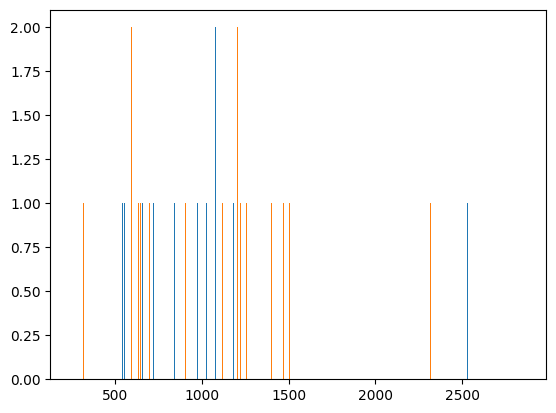

In [ ]:
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(40)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)

1178.6 1072.0 570.0718200367389 3168.0 228.0


/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


1138.32 1072.0 577.67566817376 3092.0 244.0


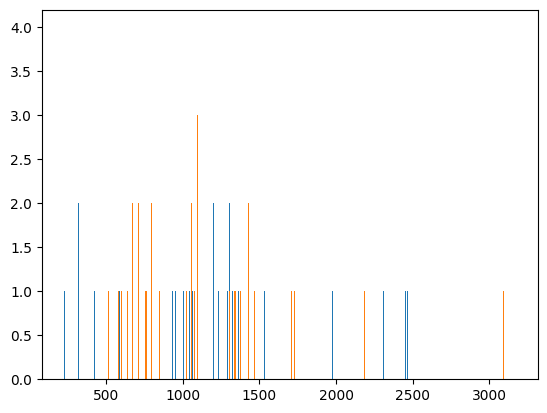

In [ ]:
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(100)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)